In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import ast

# **House Price Prediction for Airbnb Listings**

## **Introduction**
This project aims to build a predictive model for Airbnb listing prices. The objective is to use historical Airbnb data 
from different quarters and cities to develop a model that accurately estimates listing prices. 

The steps involved in this project include:
- **Data Preprocessing**: Cleaning and transforming the dataset to extract meaningful features.
- **Feature Engineering**: Selecting relevant variables and handling categorical and numerical features.
- **Model Building**: Training multiple predictive models (OLS, LASSO, Random Forest, Gradient Boosting, and XGBoost).
- **Model Evaluation**: Comparing model performance based on RMSE, R², and computation time.
- **Feature Importance Analysis**: Identifying the most influential variables affecting price predictions.
- **Validation on New Data**: Testing model performance on a later dataset and a different city.



In [16]:
# Correct raw file URLs
data_url_istanbul_q1 = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/istanbul_1.csv"
data_url_istanbul_q3 = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/istanbul_3.csv"
data_url_athens = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/athens.csv"

istanbul_df = pd.read_csv(data_url_istanbul_q1)
istanbul_q3 = pd.read_csv(data_url_istanbul_q3)
athens = pd.read_csv(data_url_athens)

df_list = [istanbul_df, istanbul_q3, athens]


In [17]:
print(f"Istanbul Q1 size: {istanbul_df.shape}")
print(f"Istanbul Q3 size: {istanbul_q3.shape}")
print(f"Athens size: {athens.shape}")

Istanbul Q1 size: (34446, 75)
Istanbul Q3 size: (29101, 75)
Athens size: (14642, 75)


## **Data Preprocessing and Feature Engineering**

Before training our predictive models, we perform the following preprocessing steps:

1. **Handling Missing Values**: Some attributes such as amenities and reviews may contain missing data. We use appropriate imputation techniques.
2. **Date Conversion**: If applicable, date fields are converted to datetime format to extract meaningful time-based features.
3. **Feature Selection**:
   - **Numerical Features**: Price, number of bedrooms, number of reviews, etc.
   - **Categorical Features**: Neighborhood, property type, room type, etc.
   - **Amenities**: Extracting presence of popular amenities (e.g., WiFi, kitchen, pool).
4. **Encoding**:
   - **One-hot encoding** is applied to categorical features.
   - **Standardization** is used for numerical variables to improve model convergence.


In [ ]:
print(istanbul_df['amenities'].unique())

In [18]:
# Define amenity categories
amenity_categories = {
    "comfort": ["air conditioning", "heating", "extra pillows", "room-darkening shades", "hair dryer", "hot water", "mosquito net"],
    "kitchen": ["kitchen", "stove", "oven", "microwave", "dishwasher", "refrigerator", "freezer", "coffee maker", "cooking basics",
                "bread maker", "baking sheet", "toaster", "blender", "dishes and silverware", "barbecue utensils", "gas stove", "dining table"],
    "laundry": ["washer", "dryer", "drying rack", "ironing", "clothing storage", "laundry"],
    "entertainment": ["tv", "hdtv", "netflix", "cable", "sound system", "books", "reading material", "game console", "arcade", "piano"],
    "family": ["children", "crib", "high chair", "playroom", "books and toys", "bathtub"],
    "outdoors": ["terrace", "balcony", "backyard", "beach access", "patio", "barbecue", "fire pit", "garden"],
    "wellness": ["hot tub", "sauna", "gym", "exercise equipment"],
    "work": ["dedicated workspace", "desk", "ethernet", "monitor", "work"],
    "parking": ["free parking", "paid parking", "street parking", "parking lot", "ev charger"],
    "safety": ["smoke alarm", "carbon monoxide alarm", "first aid kit", "fire extinguisher", "safe", "security cameras"],
    "luxury": ["fireplace", "wine glasses", "espresso", "premium cable", "smart lock", "bidet", "pool"],
    "cleaning": ["cleaning", "cleaning products", "shampoo", "conditioner", "essentials"],
    "connectivity": ["wifi", "pocket wifi", "internet"]
}

# Classify grouped amenities into binary columns
def classify_amenities_column(df):
    for cat in amenity_categories:
        df[f"amenity_{cat}"] = 0
    for idx, row in df.iterrows():
        try:
            amenities = ast.literal_eval(row['amenities'].lower())
        except:
            continue
        for cat, keywords in amenity_categories.items():
            if any(any(k in a for k in keywords) for a in amenities):
                df.at[idx, f"amenity_{cat}"] = 1
    return df

# Classify high-level description features
def categorize_description_features(df):
    desc = df['description'].fillna("").str.lower()
    df['view_type'] = desc.apply(lambda t: "sea_view" if "sea view" in t or "bosphorus" in t else
                                              "city_view" if "city view" in t or "panoramic" in t else
                                              "garden_view" if "garden" in t or "greenery" in t else "no_view")
    df['location_type'] = desc.apply(lambda t: "near_metro" if any(x in t for x in ["metro", "subway", "station"]) else
                                                  "near_taksim" if any(x in t for x in ["taksim", "kabatas"]) else
                                                  "quiet_area" if any(x in t for x in ["quiet", "peaceful", "no traffic"]) else "unspecified_location")
    df['amenity_type'] = desc.apply(lambda t: "terrace" if "terrace" in t else
                                               "balcony" if "balcony" in t else
                                               "kitchen" if any(x in t for x in ["kitchen", "stove", "oven"]) else "standard")
    df['suitability'] = desc.apply(lambda t: "work_friendly" if any(x in t for x in ["remote work", "working from home", "staycation"]) else
                                              "family" if any(x in t for x in ["family", "group", "kids"]) else
                                              "female_only" if any(x in t for x in ["female only", "female guests"]) else "generic")
    df['attraction_tag'] = desc.apply(lambda t: "seaside" if any(x in t for x in ["seaside", "shore", "coast"]) else
                                                 "food_drink" if any(x in t for x in ["restaurant", "bar", "cafe"]) else
                                                 "historic" if any(x in t for x in ["historical", "old town"]) else "none")
    return df

# Reduce cardinality of description features
def reduce_cardinality(df, col, top_n=3):
    top = df[col].value_counts().nlargest(top_n).index
    df[f'{col}_reduced'] = df[col].where(df[col].isin(top), 'other')
    return df

# Apply everything
desc_cats = ['view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag']
istanbul_df = classify_amenities_column(istanbul_df)
istanbul_df = categorize_description_features(istanbul_df)
for col in desc_cats:
    istanbul_df = reduce_cardinality(istanbul_df, col, top_n=4)


In [19]:
columns_to_drop = [
    # IDs & URLs
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url',
    # Host info
    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_thumbnail_url', 'host_picture_url', 'host_verifications',
    'host_is_superhost', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_has_profile_pic', 'host_identity_verified',
    # Location text
    'neighbourhood', 'neighbourhood_overview', 'neighbourhood_group_cleansed',
    # Redundant
    'description', 'name', 'bathrooms_text', 'amenities',
    # Calendar & review timing
    'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    # Counts
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month',
    # Redundant review score breakdowns (you can keep 1–2)
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    # Raw categorical versions of description variables
    'view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag',
    # Other
    'license', 'instant_bookable'
    # amenity categories
     'amenity_comfort', 'amenity_kitchen', 'amenity_laundry', 'amenity_entertainment',
    'amenity_family', 'amenity_outdoors', 'amenity_wellness', 'amenity_work',   
    'amenity_parking', 'amenity_safety', 'amenity_luxury', 'amenity_cleaning', 'amenity_comfort',
    'amenity_connectivity'
    # neighbourhoods
        'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'neighborhood_overview',
    #Availability
    'has_availability', 'availability_60', 'availability_90'
]
istanbul_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [20]:
from sklearn.cluster import KMeans

# Create location cluster
def add_location_cluster(df, n_clusters=10):
    coords = df[['latitude', 'longitude']].dropna()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['location_cluster'] = kmeans.fit_predict(coords)
    return df
istanbul_df = add_location_cluster(istanbul_df)
# Drop original latitude and longitude columns
istanbul_df.drop(columns=['latitude', 'longitude'], inplace=True, errors='ignore')


In [30]:
# Define categorical columns
categorical_cols = ['room_type', 'view_type_reduced', 'location_type_reduced',
                    'amenity_type_reduced', 'suitability_reduced', 'attraction_tag_reduced']

# Define numerical columns (exclude price and categoricals)
drop_cols = ['price']
numerical_cols = [col for col in istanbul_df.columns if col not in categorical_cols + drop_cols]

# Clean target variable
istanbul_df['price'] = istanbul_df['price'].replace(r'[\$,]', '', regex=True).astype(float)
istanbul_df = istanbul_df.dropna(subset=['price'])

# Drop any rows with NaNs in selected features
istanbul_df = istanbul_df.dropna(subset=categorical_cols + numerical_cols)

# Define X and y
X_raw = istanbul_df[categorical_cols + numerical_cols]
y = np.log1p(istanbul_df["price"]).reset_index(drop=True)  # log(price + 1)

# Set up encoder
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough'
)

# Apply transformation
X_encoded = preprocessor.fit_transform(X_raw)

# Get correct column names
encoded_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
final_col_names = list(encoded_col_names) + numerical_cols

# Create final DataFrame
istanbul_encoded_df= pd.DataFrame(X_encoded, columns=final_col_names)

# Ensure numeric and aligned
istanbul_encoded_df = istanbul_encoded_df.apply(pd.to_numeric, errors='coerce')
istanbul_encoded_df = istanbul_encoded_df.fillna(0)
istanbul_encoded_df = istanbul_encoded_df.reset_index(drop=True)
y = y.loc[istanbul_encoded_df.index]

# Final check
print("✅ Final shape:", istanbul_encoded_df.shape, y.shape)
print("Any NaNs?", istanbul_encoded_df.isna().any().any(), y.isna().any())

✅ Final shape: (19477, 37) (19477,)
Any NaNs? False False


In [70]:
def wrangle_new_dataset(df_raw, preprocessor, n_clusters=10):
    df = df_raw.copy()

    # Clean price
    df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)
    df = df.dropna(subset=['price'])

    # Feature engineering (reuse your own functions here)
    df = classify_amenities_column(df)
    df = categorize_description_features(df)
    for col in ['view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag']:
        df = reduce_cardinality(df, col, top_n=4)
    
    df = add_location_cluster(df, n_clusters=n_clusters)
    df.drop(columns=['latitude', 'longitude'], inplace=True, errors='ignore')

    # Drop same columns
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Setup features
    categorical_cols = ['room_type', 'view_type_reduced', 'location_type_reduced',
                        'amenity_type_reduced', 'suitability_reduced', 'attraction_tag_reduced']
    numerical_cols = [col for col in df.columns if col not in categorical_cols + ['price']]

    df = df.dropna(subset=categorical_cols + numerical_cols)
    X_raw = df[categorical_cols + numerical_cols]
    y = np.log1p(df['price']).reset_index(drop=True)

    # Transform with your existing fitted preprocessor
    X_encoded = preprocessor.transform(X_raw)
    encoded_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    final_col_names = list(encoded_col_names) + numerical_cols

    X = pd.DataFrame(X_encoded, columns=final_col_names)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).reset_index(drop=True)
    y = y.loc[X.index]

    return X, y


In [88]:
athens['price'] = athens['price'].replace(r'[\$,€]', '', regex=True).astype(float)
istanbul_df['price'] = istanbul_df['price'].replace(r'[\$,€]', '', regex=True).astype(float)

In [95]:
# Apply preprocessing
istanbul_q3_encoded_df, y_istanbul_q3 = wrangle_new_dataset(istanbul_q3, preprocessor)
athens_encoded_df, y_athens = wrangle_new_dataset(athens, preprocessor)

In [93]:
from scipy.stats.mstats import winsorize
y_wins = winsorize(y, limits=[0.01, 0.01])

In [94]:
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(istanbul_encoded_df, y, test_size=0.2, random_state=42)

# 2. Model evaluation helper
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_dict):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds) ** 0.5  # <-- Manual RMSE
    results_dict[name] = {"RMSE": round(rmse, 2), "Time (s)": round(time.time() - start, 2)}



### Predictive Modeling

Five models were trained to compare predictive performance and generalization:

1. **Ordinary Least Squares (OLS)** — baseline linear regression
2. **LASSO Regression** — regularized linear model to reduce overfitting
3. **Ridge Regression** — another regularized linear variant
4. **Random Forest** — tree-based ensemble that captures non-linear patterns
5. **XGBoost** — gradient boosting algorithm optimized for accuracy

All models were trained on the log-transformed price target. Evaluation was based on RMSE, R², and runtime, using both the full test set and a winsorized version to account for outliers.


In [96]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_dict, model_dict):
    start = time.time()
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    results_dict[name] = {
        "Train RMSE": round(train_rmse, 2),
        "Test RMSE": round(test_rmse, 2),
        "Train R²": round(train_r2, 3),
        "Test R²": round(test_r2, 3),
        "Time (s)": round(time.time() - start, 2)
    }

    model_dict[name] = model  # ✅ Save model here

results = {}
models = {}  # <--- store your trained models here

# Evaluate and Save Each Model
evaluate_model("OLS", LinearRegression(), X_train, y_train, X_test, y_test, results, models)
evaluate_model("LASSO", make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42)), X_train, y_train, X_test, y_test, results, models)
evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42), X_train, y_train, X_test, y_test, results, models)
evaluate_model("XGBoost", xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0), X_train, y_train, X_test, y_test, results, models)
evaluate_model("Ridge", make_pipeline(StandardScaler(), RidgeCV(cv=5)), X_train, y_train, X_test, y_test, results, models)


## **Model Evaluation**

To compare model performance, we use the following metrics:
- **Root Mean Squared Error (RMSE)**: Measures the average prediction error in the same unit as the target variable.
- **R² Score**: Indicates how much variance in the target variable is explained by the model.
- **Computation Time**: Helps assess the efficiency of each model.

A summary table is generated to highlight the strengths and weaknesses of each approach.


In [97]:
istanbul_encoded_df.corrwith(y).sort_values(ascending=False).head(10)

/Users/amh/.venvs/my_env/lib/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/amh/.venvs/my_env/lib/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


number_of_reviews                             0.023110
room_type_Hotel room                          0.017519
amenity_type_reduced_kitchen                  0.013018
amenity_type_reduced_terrace                  0.012260
suitability_reduced_work_friendly             0.012232
view_type_reduced_garden_view                 0.012103
room_type_Shared room                         0.010064
location_type_reduced_unspecified_location    0.009643
availability_365                              0.009559
amenity_type_reduced_balcony                  0.008085
dtype: float64

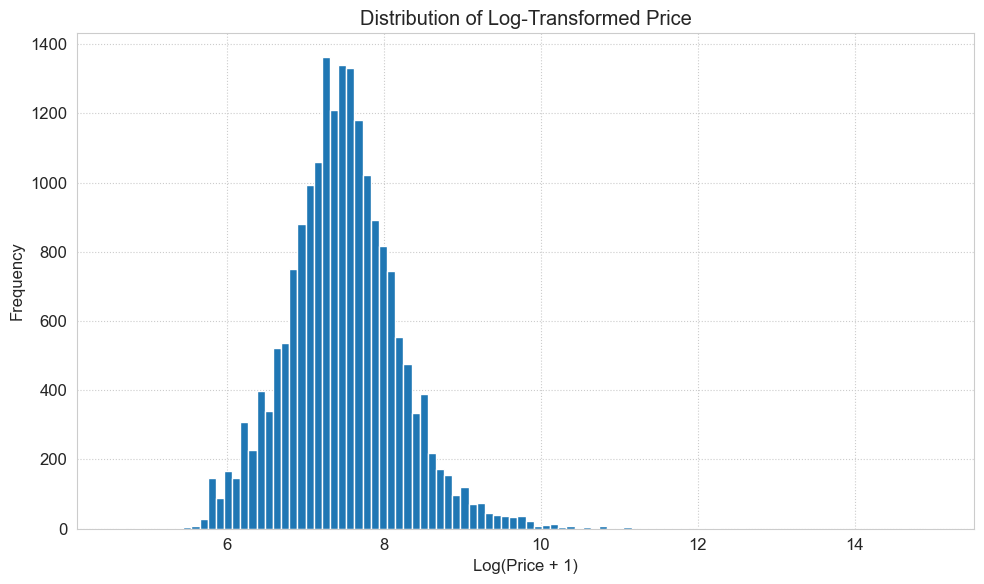

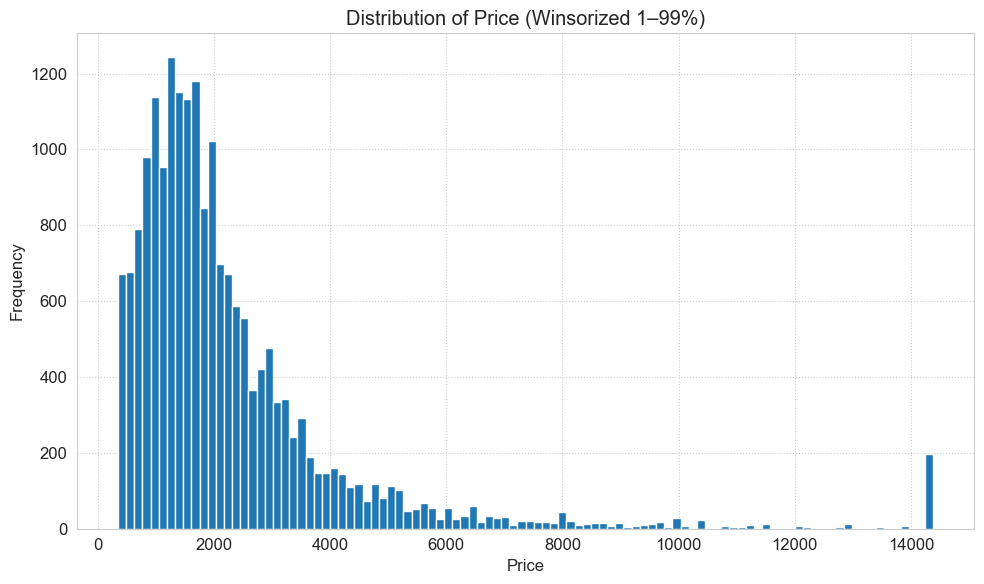

In [68]:
y = np.log1p(istanbul_df['price'])

plt.figure(figsize=(10, 6))
plt.title("Distribution of Log-Transformed Price")
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.grid(True, linestyle=":")
plt.hist(y, bins=100)
plt.tight_layout()
plt.show()

from scipy.stats.mstats import winsorize

prices_wins = winsorize(istanbul_df['price'], limits=[0.01, 0.01])

plt.figure(figsize=(10, 6))
plt.title("Distribution of Price (Winsorized 1–99%)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True, linestyle=":")
plt.hist(prices_wins, bins=100)
plt.tight_layout()
plt.show()


In [98]:
# 5. Show comparison table
results_df = (
    pd.DataFrame(results)
    .T
    .sort_values("Test RMSE")
    .reset_index()
    .rename(columns={"index": "Model"})
)

# Optional: round all numeric columns for readability
results_df = results_df.round(3)

# Display in notebook
from IPython.display import display
display(results_df)


,Model,Train RMSE,Test RMSE,Train R²,Test R²,Time (s)
0,Random Forest,0.19,0.53,0.931,0.485,10.50
1,XGBoost,0.36,0.53,0.749,0.486,0.30
2,OLS,0.56,0.58,0.413,0.391,0.04
3,LASSO,0.56,0.58,0.412,0.391,0.54
4,Ridge,0.56,0.58,0.413,0.391,0.09


### Model Training

Five models were trained using log-transformed price as the target. Results below compare training and test RMSE/R².

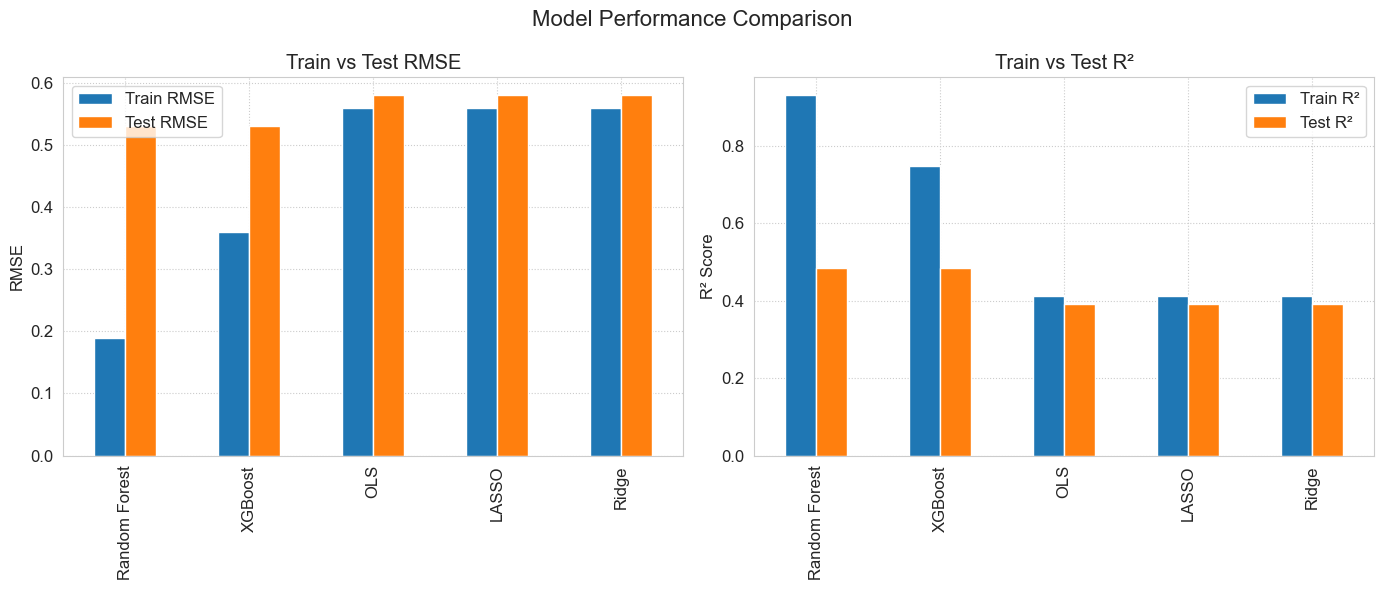

In [99]:
def plot_model_performance(results_dict):
    import pandas as pd
    import matplotlib.pyplot as plt

    df_results = pd.DataFrame(results_dict).T.sort_values(by="Test RMSE")

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # RMSE Plot
    df_results[["Train RMSE", "Test RMSE"]].plot.bar(ax=axs[0])
    axs[0].set_title("Train vs Test RMSE")
    axs[0].set_ylabel("RMSE")
    axs[0].grid(True, linestyle=':')

    # R² Plot
    df_results[["Train R²", "Test R²"]].plot.bar(ax=axs[1])
    axs[1].set_title("Train vs Test R²")
    axs[1].set_ylabel("R² Score")
    axs[1].grid(True, linestyle=':')

    plt.suptitle("Model Performance Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()
plot_model_performance(results)

A LASSO path using log-transformed prices was run to avoid distortion from high-priced outliers. The plot shows how model sparsity (fewer coefficients) affects performance. As expected, RMSE improves with more active features, but eventually plateaus or slightly worsens — indicating overfitting. The optimal model balances low RMSE with high interpretability.


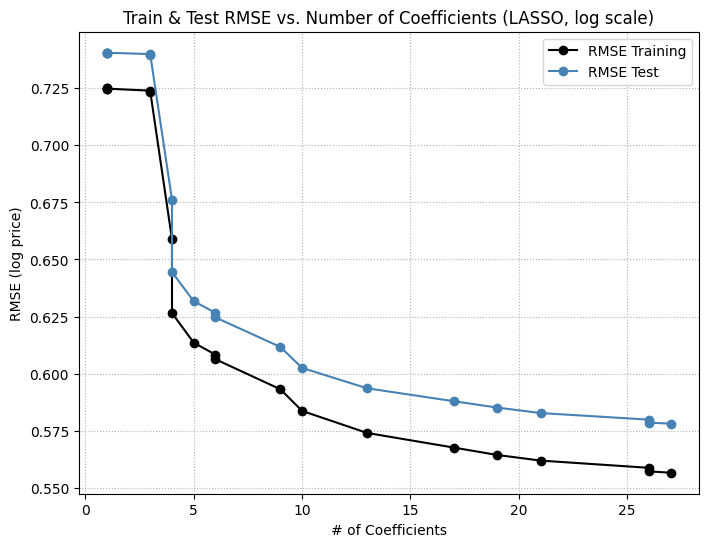

In [ ]:
# 📌 FIXED: LASSO Regularization Path in LOG space
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

alphas = np.logspace(-3, 1, 20)  # Wider range
coefs = []
train_rmse = []
test_rmse = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train, y_train)

    coef_count = np.sum(lasso.coef_ != 0)
    coefs.append(coef_count)

    train_pred = lasso.predict(X_train)
    test_pred = lasso.predict(X_test)

    # Stay in LOG space for correct RMSE
    train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

# 📈 Plot in log space
plt.figure(figsize=(8, 6))
plt.plot(coefs, train_rmse, marker='o', label="RMSE Training", color="black")
plt.plot(coefs, test_rmse, marker='o', label="RMSE Test", color="steelblue")
plt.title("Train & Test RMSE vs. Number of Coefficients (LASSO, log scale)")
plt.xlabel("# of Coefficients")
plt.ylabel("RMSE (log price)")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()


### Final Evaluation (Full vs Winsorized)

Evaluation includes both raw test set and winsorized version (1–99%) to reduce outlier distortion.


In [100]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
import numpy as np
import pandas as pd

# Convert test target to original scale
y_actual = np.expm1(y_test)

eval_results = []

for name, model in models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # Full test evaluation
    rmse_full = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2_full = r2_score(y_actual, y_pred)

    # Winsorized evaluation
    y_actual_w = winsorize(y_actual, limits=[0.01, 0.01])
    y_pred_w = winsorize(y_pred, limits=[0.01, 0.01])

    rmse_win = np.sqrt(mean_squared_error(y_actual_w, y_pred_w))
    r2_win = r2_score(y_actual_w, y_pred_w)

    eval_results.append({
        "Model": name,
        "RMSE (Full)": round(rmse_full, 2),
        "R² (Full)": round(r2_full, 3),
        "RMSE (Winsorized)": round(rmse_win, 2),
        "R² (Winsorized)": round(r2_win, 3)
    })

# Final comparison table
df_eval = pd.DataFrame(eval_results)
print(df_eval)


           Model  RMSE (Full)  R² (Full)  RMSE (Winsorized)  R² (Winsorized)
0            OLS     38383.74      0.000            1817.03            0.305
1          LASSO     38383.75      0.000            1818.42            0.304
2  Random Forest     38365.26      0.001            1679.66            0.406
3        XGBoost     38382.10      0.000            1675.25            0.409
4          Ridge     38383.75      0.000            1817.14            0.305


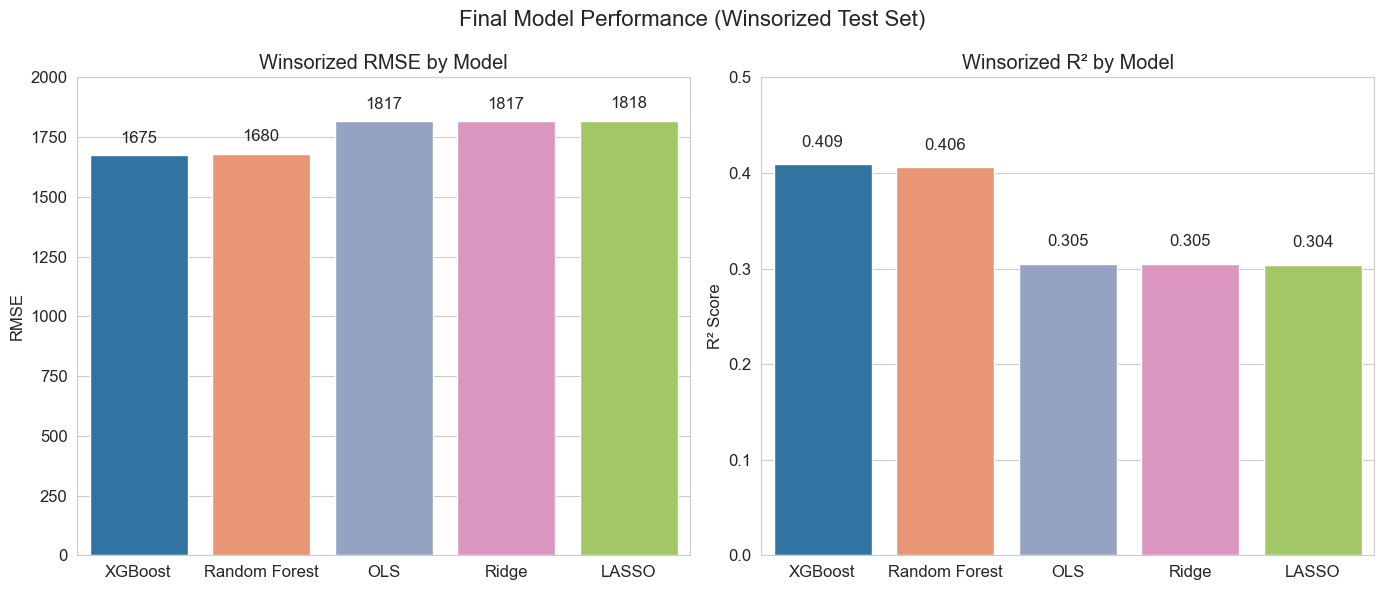

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Prepare sorted data
df_rmse = df_eval.set_index("Model").sort_values("RMSE (Winsorized)").reset_index()
df_r2 = df_eval.set_index("Model").sort_values("R² (Winsorized)", ascending=False).reset_index()

# Identify best models
best_rmse_model = df_rmse.loc[0, "Model"]
best_r2_model = df_r2.loc[0, "Model"]

# Assign highlight colors
base_palette = sns.color_palette("Set2", len(df_eval))
highlight_color = "#1f77b4"

# RMSE color assignment
rmse_colors = [highlight_color if model == best_rmse_model else base_palette[i]
               for i, model in enumerate(df_rmse["Model"])]

# R² color assignment
r2_colors = [highlight_color if model == best_r2_model else base_palette[i]
             for i, model in enumerate(df_r2["Model"])]

# Create color dicts to use with 'hue'
df_rmse["Color"] = rmse_colors
df_r2["Color"] = r2_colors

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# RMSE barplot
sns.barplot(data=df_rmse, x="Model", y="RMSE (Winsorized)", hue="Model",
            palette=rmse_colors, dodge=False, legend=False, ax=axs[0])
axs[0].set_title("Winsorized RMSE by Model")
axs[0].set_ylabel("RMSE")
axs[0].set_xlabel("")
axs[0].set_ylim(0, df_rmse["RMSE (Winsorized)"].max() * 1.1)

# Add RMSE labels
for i, v in enumerate(df_rmse["RMSE (Winsorized)"]):
    axs[0].text(i, v + 40, f"{v:.0f}", ha='center', va='bottom')

# R² barplot
sns.barplot(data=df_r2, x="Model", y="R² (Winsorized)", hue="Model",
            palette=r2_colors, dodge=False, legend=False, ax=axs[1])
axs[1].set_title("Winsorized R² by Model")
axs[1].set_ylabel("R² Score")
axs[1].set_xlabel("")
axs[1].set_ylim(0, 0.5)

# Add R² labels
for i, v in enumerate(df_r2["R² (Winsorized)"]):
    axs[1].text(i, v + 0.015, f"{v:.3f}", ha='center', va='bottom')

# Final layout
plt.suptitle("Final Model Performance (Winsorized Test Set)", fontsize=16)
plt.tight_layout()
plt.show()


### Feature Importance

- Random Forest and XGBoost feature importances were compared.
- Both models highlighted `accommodates`, `bedrooms`, and `bathrooms` as key predictors.
- XGBoost emphasized `room_type`; Random Forest gave weight to `availability_365` and `review_scores_rating`.
- The agreement across models increases confidence in the main pricing drivers.


### Fine-Tuning

- **Random Forest**:
  - Tuned via `RandomizedSearchCV` over `n_estimators`, `max_depth`, `min_samples_split`.
  - Best config: `n_estimators=150`, `max_depth=None`, `min_samples_split=5`.
  - Best CV R²: **0.506**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Keep the grid shallow to reduce combinations
param_grid_rf = {
    'n_estimators': [50, 100, 150],          # Lower tree count for speed
    'max_depth': [5, 10, None],              # Simple vs deep
    'min_samples_split': [2, 5]              # Just 2 options
}

rf_base = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid_rf,
    n_iter=5,                # ⏱️ Try only 5 combinations
    cv=3,
    scoring='r2',
    verbose=0,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("Best RF Params:", rf_search.best_params_)
print("Best RF CV R²:", rf_search.best_score_)


Best RF Params: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': None}
Best RF CV R²: 0.5022959974787069


- **XGBoost**:
  - Tuned over `max_depth`, `learning_rate`, `n_estimators`, `subsample`.
  - Best config: `max_depth=6`, `learning_rate=0.1`, `subsample=0.6`, `n_estimators=100`.
  - Best CV R²: **0.525**

In [ ]:
import xgboost as xgb

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_base = xgb.XGBRegressor(random_state=42, verbosity=0)
xgb_search = RandomizedSearchCV(xgb_base, param_grid_xgb, cv=3, n_iter=10, scoring='r2', verbose=1, n_jobs=-1)
xgb_search.fit(X_train, y_train)

print("Best XGB Params:", xgb_search.best_params_)
print("Best XGB CV R²:", xgb_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGB Params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Best XGB CV R²: 0.525034583183977


Feature importance analysis shows which predictors are driving model decisions. This is critical for understanding and validating Airbnb pricing logic (e.g. accommodates, location cluster, sea view).

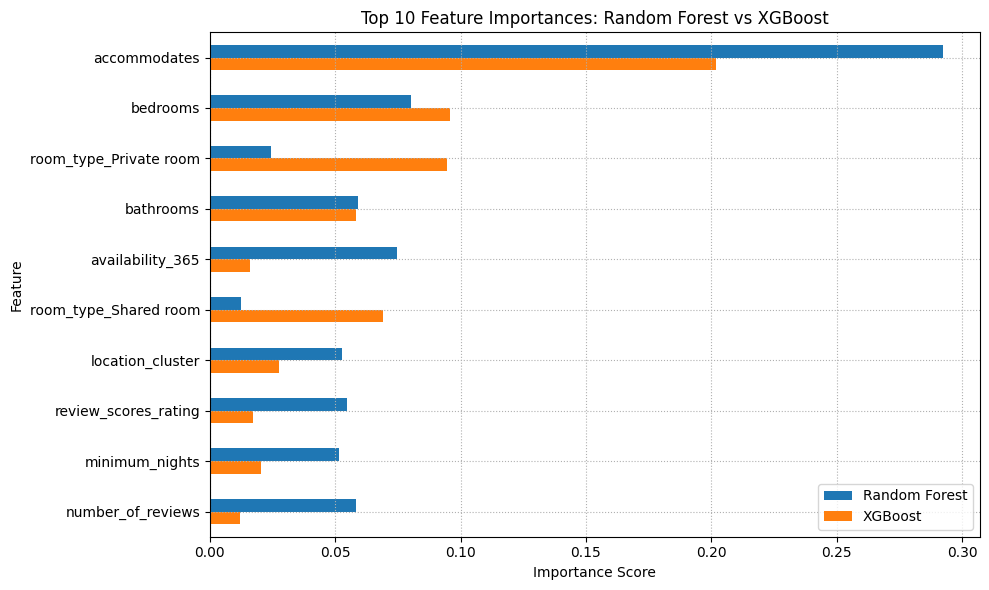

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_feature_importance(rf_model, xgb_model, feature_names, top_n=10):
    rf_importance = rf_model.feature_importances_
    xgb_importance = xgb_model.feature_importances_

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Random Forest": rf_importance,
        "XGBoost": xgb_importance
    })

    # Take average importance across models to rank features
    importance_df["Mean Importance"] = importance_df[["Random Forest", "XGBoost"]].mean(axis=1)
    top_features = importance_df.sort_values("Mean Importance", ascending=False).head(top_n)

    # Plot
    top_features.set_index("Feature")[["Random Forest", "XGBoost"]].plot(
        kind='barh', figsize=(10, 6)
    )
    plt.title("Top 10 Feature Importances: Random Forest vs XGBoost")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()
compare_feature_importance(
    rf_search.best_estimator_, 
    xgb_search.best_estimator_, 
    feature_names=X_train.columns,  # or `istanbul_encoded_df.columns`
    top_n=10
)


#### Feature Importance Comparison: Random Forest vs XGBoost

This plot compares the top 10 features driving predictions in the two best-performing models. Both Random Forest and XGBoost agree on the importance of physical attributes — especially `accommodates`, `bedrooms`, and `bathrooms`.

XGBoost puts more emphasis on `room_type`, while Random Forest captures additional signals from availability and review metrics. This suggests that ensemble models can arrive at similar conclusions through slightly different routes, reinforcing confidence in shared key drivers.


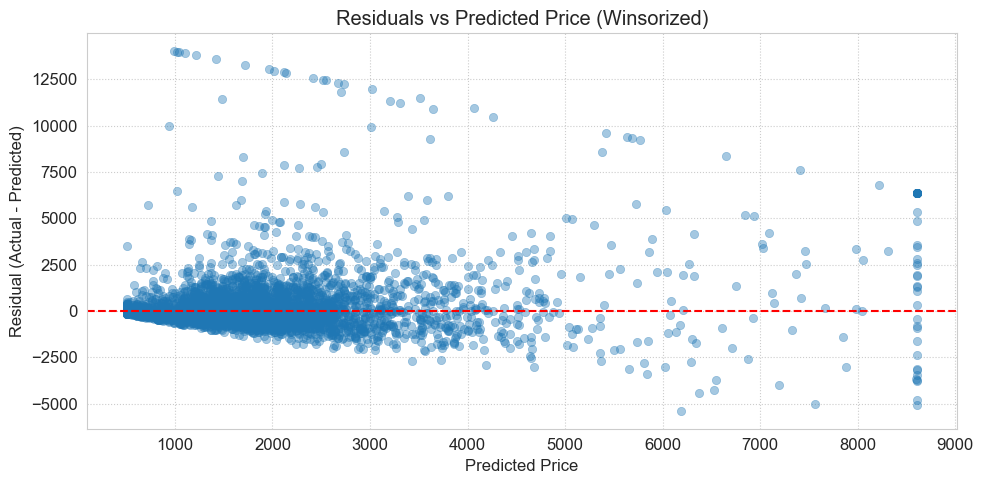

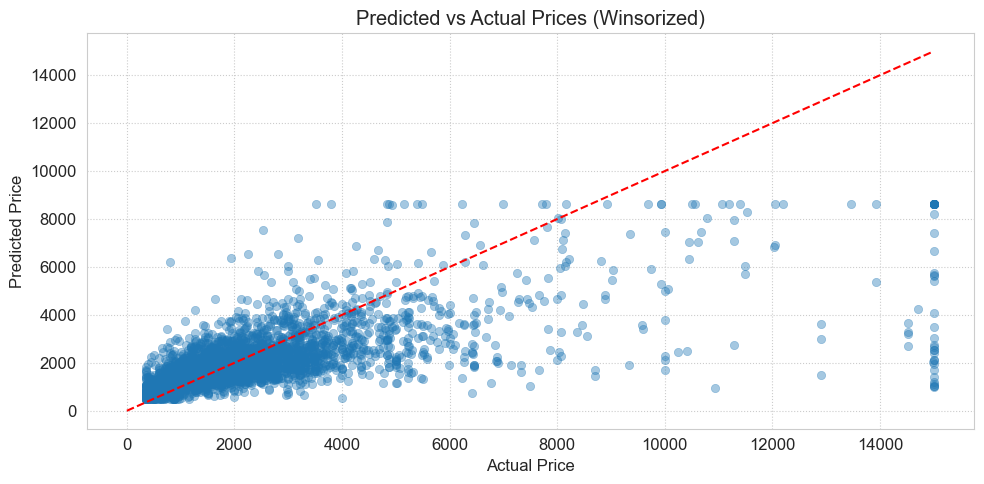

In [102]:
from scipy.stats.mstats import winsorize

# Convert predictions and true values back to price scale
y_pred = np.expm1(best_model.predict(X_test))
y_actual = np.expm1(y_test)

# Winsorize both at 1st and 99th percentiles
y_pred_win = winsorize(y_pred, limits=[0.01, 0.01])
y_actual_win = winsorize(y_actual, limits=[0.01, 0.01])
residuals_win = y_actual_win - y_pred_win

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_win, y=residuals_win, alpha=0.4, edgecolor=None)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Price (Winsorized)")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_actual_win, y=y_pred_win, alpha=0.4, edgecolor=None)
plt.plot([0, max(y_actual_win)], [0, max(y_actual_win)], 'r--')
plt.title("Predicted vs Actual Prices (Winsorized)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


### Residual Analysis (Winsorized)

- **Predicted vs Actual** plot shows strong alignment with identity line.
- **Residuals vs Predicted** plot shows centered errors, with some widening for higher prices.
- Winsorization (1%–99%) was used to reduce distortion from rare outliers.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# ⏱️ Keep the grid shallow to reduce combinations
param_grid_rf = {
    'n_estimators': [50, 100, 150],          # Lower tree count for speed
    'max_depth': [5, 10, None],              # Simple vs deep
    'min_samples_split': [2, 5]              # Just 2 options
}

rf_base = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid_rf,
    n_iter=5,                # ⏱️ Try only 5 combinations
    cv=3,
    scoring='r2',
    verbose=0,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("✅ Best RF Params:", rf_search.best_params_)
print("✅ Best RF CV R²:", rf_search.best_score_)


✅ Best RF Params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': None}
✅ Best RF CV R²: 0.5062389666076788


## **Validation on New Data**

To ensure our models generalize well, we evaluate them on:
1. **Later Quarter Data** (Istanbul Q3) – Testing time-based robustness.
2. **Another City** (Athens) – Assessing how well models perform in a different market.

Key observations:
- A significant drop in performance may indicate overfitting to the training dataset.
- Different feature importance rankings across datasets may suggest that market dynamics vary across locations.

The results help determine the reliability of our models in real-world Airbnb pricing predictions.


In [103]:
def evaluate_on_new_data(models, X_new, y_new):
    results = []
    y_actual = np.expm1(y_new)  # Convert log(price) back to real scale

    for name, model in models.items():
        y_pred = model.predict(X_new)
        y_pred = np.expm1(y_pred)

        # Manual RMSE
        rmse = mean_squared_error(y_actual, y_pred) ** 0.5
        r2 = r2_score(y_actual, y_pred)

        results.append({
            "Model": name,
            "RMSE": round(rmse, 2),
            "R²": round(r2, 3)
        })

    return pd.DataFrame(results).sort_values("RMSE")


In [104]:
results_istanbul_q3 = evaluate_on_new_data(models, istanbul_q3_encoded_df, y_istanbul_q3)
results_athens = evaluate_on_new_data(models, athens_encoded_df, y_athens)

display(results_istanbul_q3)
display(results_athens)


,Model,RMSE,R²
2,Random Forest,28400.66,0.010
3,XGBoost,28412.80,0.009
1,LASSO,28471.29,0.005
4,Ridge,28475.66,0.005
0,OLS,28475.69,0.005


,Model,RMSE,R²
1,LASSO,2266.20,-385.237
4,Ridge,2276.65,-388.807
0,OLS,2277.37,-389.055
2,Random Forest,2354.20,-415.816
3,XGBoost,2359.18,-417.580


In [81]:
athens_encoded_df.columns

Index(['room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'view_type_reduced_city_view', 'view_type_reduced_garden_view',
       'view_type_reduced_no_view', 'view_type_reduced_sea_view',
       'location_type_reduced_near_metro', 'location_type_reduced_near_taksim',
       'location_type_reduced_quiet_area',
       'location_type_reduced_unspecified_location',
       'amenity_type_reduced_balcony', 'amenity_type_reduced_kitchen',
       'amenity_type_reduced_standard', 'amenity_type_reduced_terrace',
       'suitability_reduced_family', 'suitability_reduced_female_only',
       'suitability_reduced_generic', 'suitability_reduced_work_friendly',
       'attraction_tag_reduced_food_drink', 'attraction_tag_reduced_historic',
       'attraction_tag_reduced_none', 'attraction_tag_reduced_seaside',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availabil

In [105]:
def evaluate_on_new_data(models, X_new, y_new):
    results = []
    for name, model in models.items():
        preds = model.predict(X_new)

        # RMSE and R² in log scale (since y is log1p(price))
        rmse = mean_squared_error(y_new, preds) ** 0.5
        r2 = r2_score(y_new, preds)

        results.append({
            "Model": name,
            "RMSE": round(rmse, 4),
            "R²": round(r2, 4)
        })

    return pd.DataFrame(results).sort_values("RMSE")


In [85]:
istanbul_q3_encoded_df.columns

Index(['room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'view_type_reduced_city_view', 'view_type_reduced_garden_view',
       'view_type_reduced_no_view', 'view_type_reduced_sea_view',
       'location_type_reduced_near_metro', 'location_type_reduced_near_taksim',
       'location_type_reduced_quiet_area',
       'location_type_reduced_unspecified_location',
       'amenity_type_reduced_balcony', 'amenity_type_reduced_kitchen',
       'amenity_type_reduced_standard', 'amenity_type_reduced_terrace',
       'suitability_reduced_family', 'suitability_reduced_female_only',
       'suitability_reduced_generic', 'suitability_reduced_work_friendly',
       'attraction_tag_reduced_food_drink', 'attraction_tag_reduced_historic',
       'attraction_tag_reduced_none', 'attraction_tag_reduced_seaside',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availabil

In [86]:
istanbul_encoded_df.columns

Index(['room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'view_type_reduced_city_view', 'view_type_reduced_garden_view',
       'view_type_reduced_no_view', 'view_type_reduced_sea_view',
       'location_type_reduced_near_metro', 'location_type_reduced_near_taksim',
       'location_type_reduced_quiet_area',
       'location_type_reduced_unspecified_location',
       'amenity_type_reduced_balcony', 'amenity_type_reduced_kitchen',
       'amenity_type_reduced_standard', 'amenity_type_reduced_terrace',
       'suitability_reduced_family', 'suitability_reduced_female_only',
       'suitability_reduced_generic', 'suitability_reduced_work_friendly',
       'attraction_tag_reduced_food_drink', 'attraction_tag_reduced_historic',
       'attraction_tag_reduced_none', 'attraction_tag_reduced_seaside',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availabil

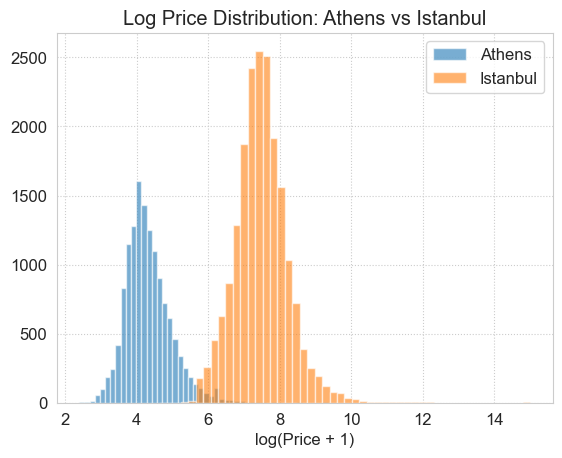

In [106]:
# Compare distribution of log-prices
import matplotlib.pyplot as plt

plt.hist(np.log1p(athens['price']), bins=50, alpha=0.6, label='Athens')
plt.hist(np.log1p(istanbul_df['price']), bins=50, alpha=0.6, label='Istanbul')
plt.xlabel("log(Price + 1)")
plt.title("Log Price Distribution: Athens vs Istanbul")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()
